## Install Dependecies

### Pip installation (can be skipped if already done once)

In [6]:
#%%capture
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
%pip install -r requirements.txt
%pip install -q optimum["onnxruntime"]
%pip install -U xformers --index-url https://download.pytorch.org/whl/cu124
%pip install --upgrade torch diffusers
#%%matplotlib inline

Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip list

Package                  Version
------------------------ ------------
accelerate               0.34.2
aiohappyeyeballs         2.4.0
aiohttp                  3.10.6
aiosignal                1.3.1
asttokens                2.4.1
attrs                    24.2.0
blinker                  1.8.2
build                    1.2.2
certifi                  2024.8.30
charset-normalizer       3.3.2
click                    8.1.7
cmake                    3.30.3
colorama                 0.4.6
coloredlogs              15.0.1
comm                     0.2.2
contourpy                1.3.0
cycler                   0.12.1
datasets                 3.0.0
debugpy                  1.8.6
decorator                5.1.1
diffusers                0.30.3
dill                     0.3.8
evaluate                 0.4.3
executing                2.1.0
filelock                 3.16.1
Flask                    3.0.3
flatbuffers              24.3.25
fonttools                4.54.1
frozenlist               1.4.1
fsspec         

### Module Importation

In [3]:
import cv2
from PIL import Image
import numpy as np
import keyboard
from IPython.display import display, clear_output
import ipywidgets
from diffusers import AutoPipelineForImage2Image, EulerAncestralDiscreteScheduler, StableDiffusionXLControlNetPipeline, ControlNetModel
from diffusers.utils import load_image
import torch
import os
from optimum.onnxruntime import ORTStableDiffusionXLPipeline
import threading
from diffusers.models.attention_processor import AttnProcessor2_0
from transformers import CLIPVisionModelWithProjection

if os.getenv('TRANSFORMERS_CACHE') and os.getenv('HF_HOME'):
    pass
else :
    new_path = input("Write path to where models should be downloaded")
    os.environ['HF_HOME'] = new_path
    os.environ['TRANSFORMERS_CACHE'] = new_path    #path to downloaded models

torch.backends.cuda.matmul.allow_tf32 = True       #use 32 precision floats

## Define functions and classes

In [4]:
class WebcamCapture:
    def __init__(self, cam_index=0):
        # Initialize the webcam once
        self.cap = cv2.VideoCapture(cam_index)
        if not self.cap.isOpened():
            raise Exception("Could not open video device")
    
    def capture_image(self):
        # Capture a single frame
        ret, frame = self.cap.read()
        if not ret:
            raise Exception("Failed to capture image")

        # Convert the captured frame (BGR) to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        cropped_frame = frame_rgb[0:480,80:560]
        # Convert NumPy array to PIL Image
        image = Image.fromarray(cropped_frame).resize((512,512))
        
        return image

    def release(self):
        # Release the webcam when done
        self.cap.release()

class SDPipeline:
    def __init__(self, model_name="stabilityai/sdxl-turbo", seed=314159, pipe_type=""):
        # Store pipe info
        self.model_name = model_name
        self.pipe_type = pipe_type
        # Initialize the SD pipeline
        if self.pipe_type == "ORT":
            self.pipe = ORTStableDiffusionXLPipeline.from_pretrained(model_name, torch_dtype=torch.float16, variant="fp16", use_safetensors=True).to("cuda")
        else:
            self.pipe = AutoPipelineForImage2Image.from_pretrained(model_name, torch_dtype=torch.float16, variant="fp16", use_safetensors=True).to("cuda")
        # Set scheduler
        self.pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(self.pipe.scheduler.config, use_safetensors=True)
        # Initialize generator
        self.seed = seed
        self.generator = torch.Generator(device="cuda").manual_seed(seed)
        #Initialize adapter fields to None
        self.adapter_image=None
        self.image_encoder=None
        
    def transform_image(self, prompt, input_image, num_steps=2, cfg=1.0, strength=0.5, return_type="image"):
        input_image = load_image(input_image)
        if self.adapter_image==None :
            output = self.pipe(prompt, image=input_image, num_inference_steps=num_steps, strength=strength, guidance_scale=cfg, generator=self.generator)
        else :
            output = self.pipe(prompt, image=input_image, ip_adapter_image=self.adapter_image, num_inference_steps=num_steps, strength=strength, guidance_scale=cfg, generator=self.generator)
        # Access the generated image correctly
        self.output_image = output.images[0]
        return self.output_image
    
    def accelerate_pipe(self):
        #self.pipe.unet.set_attn_processor(AttnProcessor2_0())
        #self.pipe.unet = torch.compile(self.pipe.unet, mode="reduce-overhead", fullgraph=True)
        self.pipe.to("cuda")
        self.pipe.upcast_vae()
        self.pipe.enable_vae_slicing()
        self.pipe.enable_vae_tiling()
        self.pipe.enable_xformers_memory_efficient_attention()
        #self.pipe.enable_model_cpu_offload()

    def add_ip_adapter(self,image):
        self.adapter_image=image
        self.image_encoder=CLIPVisionModelWithProjection.from_pretrained("h94/IP-Adapter",subfolder="models/image_encoder",torch_dtype=torch.float16, use_safetensors=True)
        if self.pipe_type == "ORT":
            self.pipe = ORTStableDiffusionXLPipeline.from_pretrained(self.model_name, torch_dtype=torch.float16, variant="fp16", image_encoder=self.image_encoder, use_safetensors=True).to("cuda")
        else:
            self.pipe = AutoPipelineForImage2Image.from_pretrained(self.model_name, torch_dtype=torch.float16, variant="fp16", image_encoder=self.image_encoder, use_safetensors=True).to("cuda")
        self.accelerate_pipe()
        self.pipe.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter-plus_sdxl_vit-h.bin")
        self.pipe.set_ip_adapter_scale(0.7)
        
class CNPipeline:
    def __init__(self, model_name="stabilityai/sdxl-turbo", control_net="diffusers/controlnet-depth-sdxl-1.0",seed=314159):
        # Store pipe info
        self.model_name = model_name
        # Initialize the ControlNet
        self.controlnet = ControlNetModel.from_pretrained("diffusers/controlnet-depth-sdxl-1.0" , torch_dtype=torch.float16, use_safetensors=True)
        # Initialize the SDXLPipe
        self.pipe = StableDiffusionXLControlNetPipeline.from_pretrained(self.model_name, controlnet=self.controlnet, torch_dtype=torch.float16, use_safetensors=True)
        # Set scheduler
        self.pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(self.pipe.scheduler.config)
        # Initialize generator
        self.seed = seed
        self.generator = torch.Generator(device="cuda").manual_seed(seed)
        #Initialize adapter fields to None
        self.adapter_image=None
        self.image_encoder=None
        
    def transform_image(self, prompt, num_steps=1, cfg=1.0, strength=1, return_type="image"):
        if self.adapter_image==None :
            output = self.pipe(prompt, image=self.control_image, controlnet_conditioning_scale=self.controlnet_conditioning_scale, num_inference_steps=num_steps, strength=strength, guidance_scale=cfg, generator=self.generator)
        else :
            output = self.pipe(prompt, image=self.control_image, controlnet_conditioning_scale=self.controlnet_conditioning_scale, ip_adapter_image=self.adapter_image, num_inference_steps=num_steps, strength=strength, guidance_scale=cfg, generator=self.generator)
        # Access the generated image correctly
        self.output_image = output.images[0]
        return self.output_image
    
    def accelerate_pipe(self):
        #self.pipe.unet.set_attn_processor(AttnProcessor2_0())
        #self.pipe.unet = torch.compile(self.pipe.unet, mode="reduce-overhead", fullgraph=True)
        self.pipe.to("cuda")
        self.pipe.upcast_vae()
        self.pipe.enable_vae_slicing()
        self.pipe.enable_vae_tiling()
        self.pipe.enable_xformers_memory_efficient_attention()
        #self.pipe.enable_model_cpu_offload()

    def add_ip_adapter(self,image):
        self.adapter_image=image
        self.image_encoder=CLIPVisionModelWithProjection.from_pretrained("h94/IP-Adapter",subfolder="models/image_encoder",torch_dtype=torch.float16, use_safetensors=True)
        self.pipe = StableDiffusionXLControlNetPipeline.from_pretrained(self.model_name, controlnet=self.controlnet, torch_dtype=torch.float16, variant="fp16", image_encoder=self.image_encoder, use_safetensors=True).to("cuda")
        self.accelerate_pipe()
        self.pipe.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter-plus_sdxl_vit-h.bin")
        self.pipe.set_ip_adapter_scale(0.7)
        
    def load_control_image(self,image,conditioning=1.0):
        self.control_image = image
        self.controlnet_conditioning_scale = conditioning
        
def invert_image(image):
    # Convert image to RGB mode if it's not in RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert the image to a NumPy array
    image_np = np.array(image)

    # Invert the colors by subtracting pixel values from 255
    inverted_np = 255 - image_np

    # Convert back to a PIL image
    inverted_image = Image.fromarray(inverted_np)
    
    return inverted_image

def blend_images(image1, image2, alpha=0.35):
    # Ensure images are the same size
    if image1.size != image2.size:
        raise ValueError("Images must be the same size for blending.")

    # Ensure both images are in the same mode (e.g., both RGB or RGBA)
    if image1.mode != image2.mode:
        image2 = image2.convert(image1.mode)

    # Blend the images using the alpha ratio
    blended_image = Image.blend(image1, image2, alpha)
    
    return blended_image

def concatenate_images(image1, image2):
    # Ensure both images are in RGB mode
    if image1.mode != 'RGB':
        image1 = image1.convert('RGB')
    if image2.mode != 'RGB':
        image2 = image2.convert('RGB')

    # Resize the images if needed to ensure they have the same height
    if image1.height != image2.height:
        # Resize image2 to match image1 height, keeping aspect ratio
        image2 = image2.resize((int(image2.width * (image1.height / image2.height)), image1.height))
    
    # Concatenate images
    concatenated_image = Image.new('RGB', (image1.width + image2.width, image1.height))
    concatenated_image.paste(image1, (0, 0))
    concatenated_image.paste(image2, (image1.width, 0))
    
    return concatenated_image

class GifFrameCacher:
    def __init__(self, gif_path):
        self.gif = Image.open(gif_path)
        self.frame_cache = []
        self._cache_all_frames()

    def _cache_all_frames(self):
        """Cache all frames of the GIF."""
        try:
            while True:
                # Cache the current frame
                self.frame_cache.append(self.gif.copy())
                # Move to the next frame
                self.gif.seek(self.gif.tell() + 1)
        except EOFError:
            # When no more frames are available
            pass

    def get_frame(self, frame_index):
        """Retrieve a frame by its index."""
        if 0 <= frame_index < len(self.frame_cache):
            return self.frame_cache[frame_index]
        else:
            print(f"Frame index {frame_index} is out of range.")
            return None

    def get_total_frames(self):
        """Get the total number of frames."""
        return len(self.frame_cache)
    
    def resize_frames(self, width, height):
        """Resize all cached frames to the specified width and height."""
        resized_frames = []
        for frame in self.frame_cache:
            resized_frame = frame.resize((width, height), Image.Resampling.LANCZOS)
            resized_frames.append(resized_frame)
        self.frame_cache = resized_frames
        print(f"All frames resized to {width}x{height}.")

def triangular_scheduler(index, max_index):
    """
    Generates an index that loops through values in a triangular pattern.
    
    :param index: The current index (starts from 0).
    :param max_index: The maximum index for the triangular loop (exclusive).
    :return: The new frame index and the updated internal index for the next call.
    """
    # Triangular logic: increasing then decreasing
    if index < max_index:
        result = index
    else:
        result = 2 * max_index - index

    # Update index for next call
    index = (index + 1) % (2 * max_index)

    return result, index

def compute_bounding_box_center_and_size(image):
    """
    Compute the center and size of the bounding box for a white object in a black image.
    
    :param image: Input image (PIL Image).
    :return: A tuple containing the (center_x, center_y, width, height) of the bounding box.
    """
    # Convert the image to grayscale and then to a numpy array directly
    img_array = np.array(image.convert("L"))
    
    # Threshold the image to binary (assuming the object is white and the background is black)
    binary_image = img_array > 128  # Adjust threshold if necessary
    
    # Check if there are any white pixels (early exit)
    if not np.any(binary_image):
        return None
    
    # Find the coordinates of the white pixels (bounding box corners)
    rows = np.any(binary_image, axis=1)
    cols = np.any(binary_image, axis=0)
    
    # Get the min and max row and column indices where white pixels are found
    min_y, max_y = np.where(rows)[0][[0, -1]]
    min_x, max_x = np.where(cols)[0][[0, -1]]
    
    # Compute center and size
    center_x = (min_x + max_x) // 2
    center_y = (min_y + max_y) // 2
    width = max_x - min_x
    height = max_y - min_y
    
    return (center_x, center_y, width, height)

def drawPerspective(image_height, image_width, box_height, box_width, center_x, center_y):
    # Initialize a results array with zeros
    results = np.zeros((1, image_height, image_width, 3), dtype=np.float32)

    left = center_x - box_width // 2
    right = center_x + box_width // 2
    top = center_y - box_height // 2
    bottom = center_y + box_height // 2
    
    lim_x = max(left, image_width - right)
    lim_y = max(top, image_height - bottom)
    expand_limit = max(lim_x, lim_y) - 1

    # Precompute gradient values
    values = np.arange(expand_limit + 1) / expand_limit

    for ex in range(expand_limit):
        left -= 1
        right += 1
        top -= 1
        bottom += 1

        top_clamped = max(top, 0)
        bottom_clamped = min(bottom, image_height - 1)
        left_clamped = max(left, 0)
        right_clamped = min(right, image_width - 1)

        # Only perform assignments if indices are within bounds
        if left >= 0:
            results[0, top_clamped:bottom_clamped, left, :] = values[ex]
        if right < image_width:
            results[0, top_clamped:bottom_clamped, right, :] = values[ex]
        if top >= 0:
            results[0, top, left_clamped:right_clamped, :] = values[ex]
        if bottom < image_height:
            results[0, bottom, left_clamped:right_clamped, :] = values[ex]

    # Convert results to uint8 and remove the extra dimension
    results_image = (results[0] * 255).astype(np.uint8)

    # Create a PIL image from the NumPy array
    pil_image = Image.fromarray(results_image)

    return pil_image

def screen_blend(source_image, target_image):
    """
    Blend the white values from a black and white source image onto a target RGB image using screen blending.

    :param source_image: A PIL Image object (black and white).
    :param target_image: A PIL Image object (target RGB for blending).
    :return: A new PIL Image with screen blended values from the source image onto the target image.
    """
    # Ensure the source image is in grayscale
    source_image = source_image.convert("L")  # Convert to grayscale if not already

    # Ensure the target image is in RGB mode
    target_image = target_image.convert("RGB")  # Ensure target is in RGB

    # Create a new image for the result
    blended_image = Image.new("RGB", target_image.size)

    # Get the pixel data for both images
    source_pixels = source_image.load()
    target_pixels = target_image.load()
    blended_pixels = blended_image.load()

    # Perform screen blending
    for y in range(target_image.height):
        for x in range(target_image.width):
            # Get the grayscale value from the source image
            source_value = source_pixels[x, y]

            # Get the RGB values from the target image
            target_r, target_g, target_b = target_pixels[x, y]

            # Calculate the screen blended values
            blended_r = 255 - ((255 - target_r) * (255 - source_value) // 255)
            blended_g = 255 - ((255 - target_g) * (255 - source_value) // 255)
            blended_b = 255 - ((255 - target_b) * (255 - source_value) // 255)

            # Set the blended pixel in the new image
            blended_pixels[x, y] = (blended_r, blended_g, blended_b)

    return blended_image

# Global variable to control the main loop
looping = True

def keyboard_listener():
    global looping
    keyboard.wait('esc')  # Blocks until the 'esc' key is pressed
    looping = False      # Set the stop signal
    

## Main Code

### Classic Effect Loop

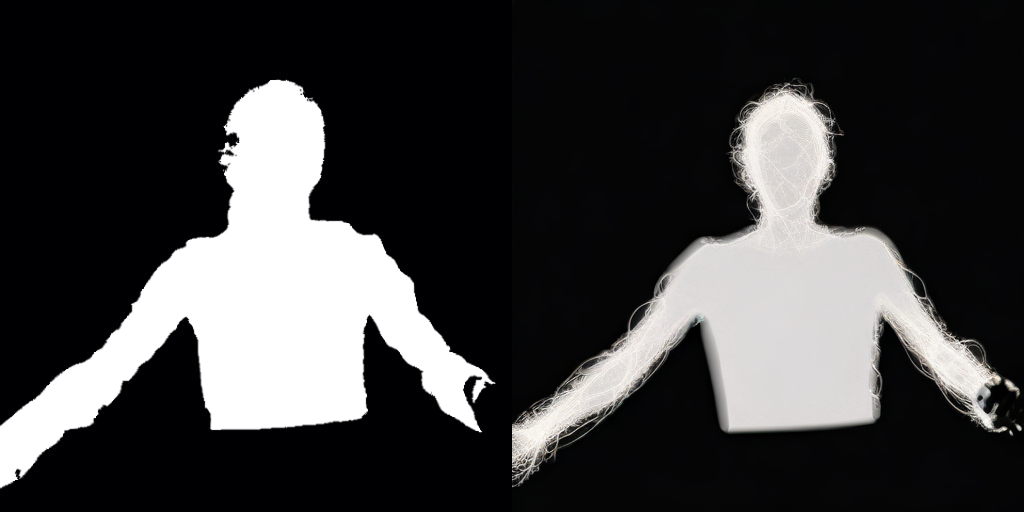

exited loop and cleared objects


In [6]:
# Open Webcam
webcam = WebcamCapture(cam_index=0)

# Create Pipeline
pipeline = SDPipeline()
pipeline.accelerate_pipe()

# Start the keyboard listener in a separate thread
listener_thread = threading.Thread(target=keyboard_listener)
listener_thread.start()

# Initialize output_image once before the loop
output_image = Image.new("RGB",(512,512))

looping=True
while looping:
    # Capture and process the input image
    input_image = invert_image(webcam.capture_image())
    # Blend last output with new input
    blended_image = blend_images(input_image, output_image.resize((512,512)), 0.35)
    # Transform the image with the pipeline
    output_image = pipeline.transform_image("Abstract, made of electricity, sparks, energy, golden.", input_image=blended_image)
    # Concatenate the images for display
    concatenated_image = concatenate_images(input_image, output_image)
    # Clear previous output and display the concatenated image
    clear_output(wait=True)
    display(concatenated_image)

# Wait for the keyboard listener thread to finish
listener_thread.join()
webcam.release()
print("exited loop and cleared objects")

### Adapter Effect Loop

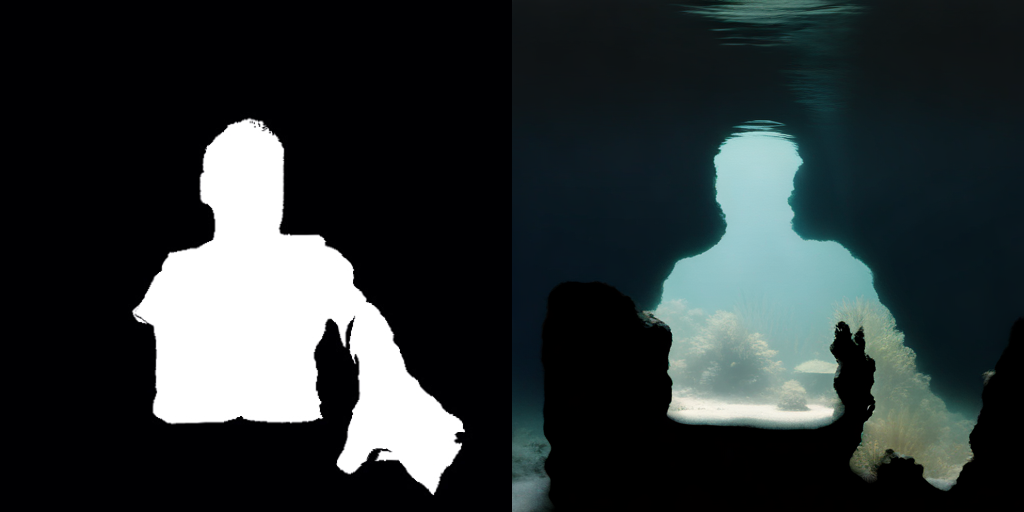

exited loop and cleared objects


In [5]:
# Open Webcam
webcam = WebcamCapture(cam_index=0)

# Create Pipeline
pipeline = SDPipeline()
pipeline.accelerate_pipe()
adapter_image = load_image("Images/underwater.png")
pipeline.add_ip_adapter(adapter_image)

# Start the keyboard listener in a separate thread
listener_thread = threading.Thread(target=keyboard_listener)
listener_thread.start()

# Initialize output_image once before the loop
output_image = Image.new("RGB",(512,512))

looping=True
while looping:
    # Capture and process the input image
    input_image = invert_image(webcam.capture_image())
    # Blend last output with new input
    blended_image = blend_images(input_image, output_image.resize((512,512)), 0.35)
    # Transform the image with the pipeline
    output_image = pipeline.transform_image("underwater landscape", input_image=blended_image)
    # Concatenate the images for display
    concatenated_image = concatenate_images(input_image,output_image)
    # Clear previous output and display the concatenated image
    clear_output(wait=True)
    display(concatenated_image)

# Wait for the keyboard listener thread to finish
listener_thread.join()
webcam.release()
print("exited loop and cleared objects")

### Background Effect Loop

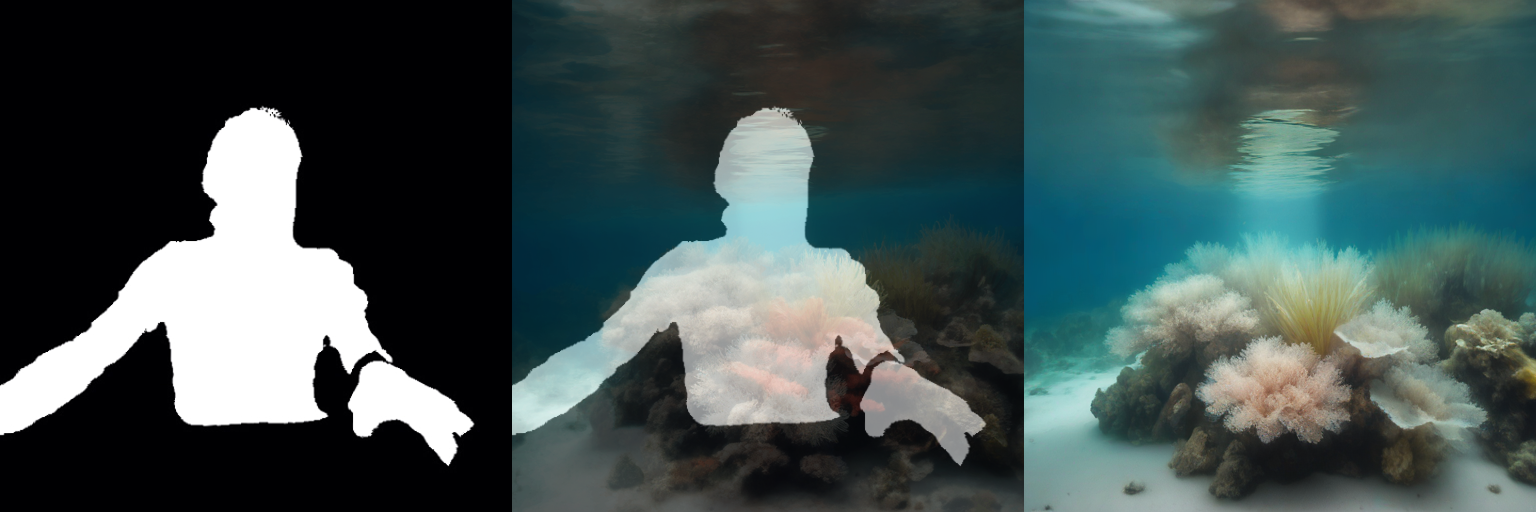

exited loop and cleared objects


In [6]:
# Open Webcam
webcam = WebcamCapture(cam_index=0)

# Create Pipeline
pipeline = SDPipeline()
pipeline.accelerate_pipe()
adapter_image = load_image("Images/underwater.png")
pipeline.add_ip_adapter(adapter_image)

# Start the keyboard listener in a separate thread
listener_thread = threading.Thread(target=keyboard_listener)
listener_thread.start()

# Initialize output_image once before the loop
output_image = Image.new("RGB",(512,512))

gif_cacher = GifFrameCacher("Images/underwater.gif") # Cache every frame of the gif for easier access later on
gif_cacher.resize_frames(512,512) # Resize every frame to the correct size
max_index = gif_cacher.get_total_frames()-1
index = 0

looping=True
while looping:
    # Capture and process the input image
    input_image = invert_image(webcam.capture_image())
    # Blend last output with new input
    blended_image = blend_images(input_image, output_image.resize((512,512)), 0.35)
    # Get the correct index
    frame_index, index = triangular_scheduler(index, max_index)
    print(frame_index,index,max_index)
    # Retrieve gif frame
    background_frame = gif_cacher.get_frame(frame_index)
    # Blend frame with the input
    background_input = blend_images(blended_image, background_frame, 0.20)
    # Transform the image with the pipeline
    output_image = pipeline.transform_image("underwater landscape", input_image=background_input)
    # Concatenate the images for display
    concatenated_image = concatenate_images(concatenate_images(input_image,background_input),output_image)
    # Clear previous output and display the concatenated image
    clear_output(wait=True)
    display(concatenated_image)

# Wait for the keyboard listener thread to finish
listener_thread.join()
webcam.release()
print("exited loop and cleared objects")

### Perspective Effect Loop

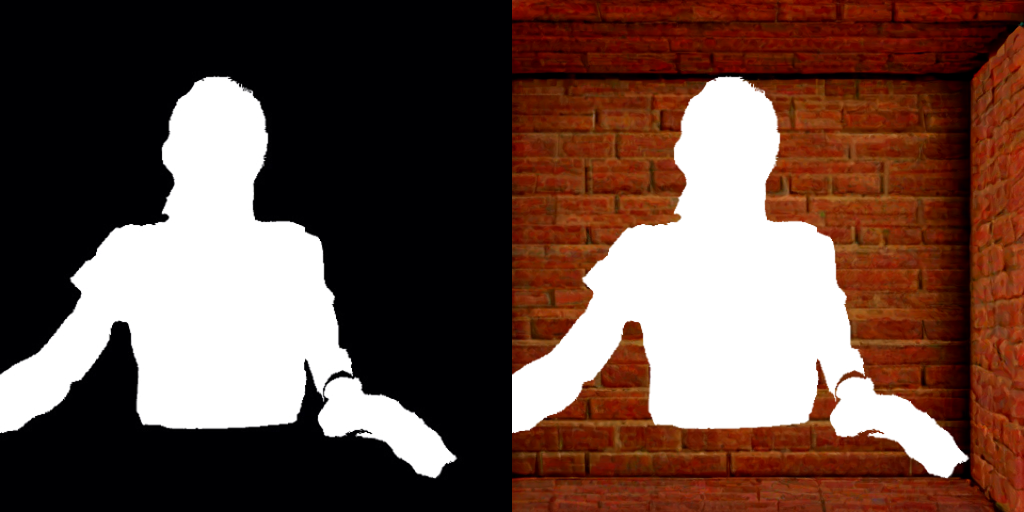

exited loop and cleared objects


In [4]:
# Open Webcam
webcam = WebcamCapture(cam_index=0)

# Create Pipeline
pipeline = CNPipeline() #ControlNet pipeline
pipeline.accelerate_pipe()
adapter_image = load_image("Images/bricks.png")
pipeline.add_ip_adapter(adapter_image)

# Start the keyboard listener in a separate thread
listener_thread = threading.Thread(target=keyboard_listener)
listener_thread.start()

# Initialize output_image once before the loop
output_image = Image.new("RGB",(512,512))

looping = True
while looping:
    # Capture and process the input image
    input_image = invert_image(webcam.capture_image())
    # Compute bounding box
    bbox_center_and_size = compute_bounding_box_center_and_size(input_image)
    if bbox_center_and_size:
        center_x, center_y, box_width, box_height = bbox_center_and_size
    # Draw ControlNet depth map
    perspective = drawPerspective(512,512,box_height,box_width,center_x,center_y)
    # Load the control image in the pipeline
    pipeline.load_control_image(perspective)
    # Transform the image with the pipeline
    output_image = pipeline.transform_image("perspective, brick wall, highly detailed")
    output_image = screen_blend(input_image,output_image)
    concatenated_image = concatenate_images(input_image,output_image)
    clear_output(wait=True)
    display(concatenated_image)
    
# Wait for the keyboard listener thread to finish
listener_thread.join()
webcam.release()
print("exited loop and cleared objects")